processed_scores columns: ['Prompt_Id', 'condition', 'CMP', 'CSAT', 'HL', 'PI', 'reply_id', 'bot_mask', 'reply_text']
answers_long columns: ['participant_id', 'question_text', 'response', 'q_norm', 'question_text_bm', 'pair_id', 'chatbot', 'scenario']
        n  mean_delta    sem      t      p
metric                                    
PI      5      -0.193  0.052 -3.733  0.020
CSAT    3      -0.091  0.101 -0.906  0.461
HL      3       0.095  0.197  0.483  0.677
CMP     3      -0.412  0.361 -1.141  0.372


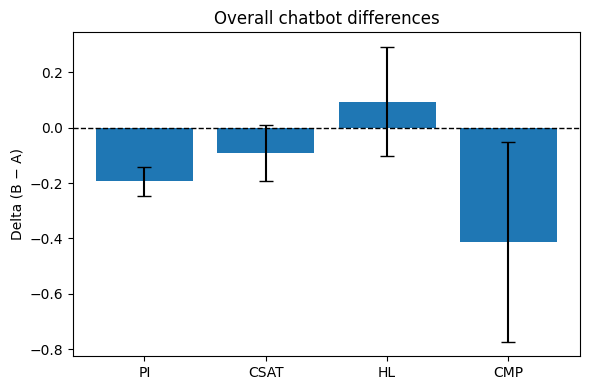

qa ok


In [1]:
# analysis from processed_scores + quick QA
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path

# helpers
def robust_read_csv(path):
    # try common encodings and separators
    for enc in ["utf-8-sig", "utf-8", "cp1252", "latin1"]:
        for sep in [",", ";", "\t"]:
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep)
                return df
            except Exception:
                pass
    raise RuntimeError(f"could not read {path}")

# load inputs
ps = robust_read_csv("processed_scores.csv")   # processed scores (Prompt_Id × condition)
al = robust_read_csv("answers_long.csv")       # long data (participant × item)

print("processed_scores columns:", list(ps.columns))
print("answers_long columns:", list(al.columns)[:8])

# set up metrics
metrics_all = ["PI", "CSAT", "HL", "CMP"]
metrics = [m for m in metrics_all if m in ps.columns]
if not metrics:
    raise ValueError(f"no metric columns in processed_scores: {list(ps.columns)}")

# aggregate to Prompt × Condition (safe even if already aggregated)
agg = ps.groupby(["Prompt_Id", "condition"], as_index=False)[metrics].mean()

# pivot A and B side by side
pv = agg.pivot(index="Prompt_Id", columns="condition", values=metrics)
pv.columns = [f"{m}_{c}" for m, c in pv.columns]
pv = pv.reset_index()

# compute B - A deltas per prompt
for m in metrics:
    a, b = f"{m}_A", f"{m}_B"
    if a in pv.columns and b in pv.columns:
        pv[f"Delta_{m}"] = pv[b] - pv[a]

# summarize across prompts with Welch 1-sample t-test on deltas
rows = []
for m in metrics:
    dcol = f"Delta_{m}"
    if dcol not in pv.columns:
        continue
    deltas = pd.to_numeric(pv[dcol], errors="coerce").dropna()
    n = len(deltas)
    if n == 0:
        rows.append(dict(metric=m, n=0, mean_delta=np.nan, sem=np.nan, t=np.nan, p=np.nan))
        continue
    mean_delta = deltas.mean()
    sem = deltas.std(ddof=1) / np.sqrt(n) if n > 1 else np.nan
    if n > 1:
        t, p = stats.ttest_1samp(deltas, 0.0, nan_policy="omit")
    else:
        t, p = np.nan, np.nan
    rows.append(dict(metric=m, n=n, mean_delta=mean_delta, sem=sem, t=t, p=p))

summary_df = pd.DataFrame(rows).set_index("metric").reindex(metrics)
summary_df = summary_df.round(3)
print(summary_df)

# save artifacts
pv.to_csv("analysis_per_prompt.csv", index=False, encoding="utf-8-sig")
summary_df.to_csv("analysis_summary.csv", encoding="utf-8-sig")

# plot overall B-A deltas with SEM error bars
if not summary_df.empty and "mean_delta" in summary_df:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(summary_df.index, summary_df["mean_delta"], yerr=summary_df["sem"], capsize=5)
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_ylabel("Delta (B − A)")
    ax.set_title("Overall chatbot differences")
    plt.tight_layout()
    plt.show()
else:
    print("nothing to plot")

# quick QA
# check 4 metrics exist
need_cols = {"PI", "CSAT", "HL", "CMP"}
missing = sorted(list(need_cols - set(ps.columns)))
assert not missing, f"missing columns in processed_scores: {missing}"

# check CSAT present in long data
assert (al["construct"].astype(str).str.upper() == "CSAT").any(), "no CSAT rows in answers_long"

# check each prompt in processed_scores has at least one condition recorded
cov = (ps.groupby("Prompt_Id")["condition"]
         .apply(lambda s: sorted(s.dropna().unique().tolist())))
assert cov.apply(len).ge(1).all(), "a prompt has no A or B rows in processed_scores"
print("qa ok")
